In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from scipy.stats import rankdata
from scipy import sparse

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")


In [2]:
df = pd.read_csv("../data/raw/fraud_dataset_v2.csv")

label = "label"

labels_orig = df[label].values          # ONLY for evaluation
X_df = df.drop(columns=[label])


In [3]:
df[label].value_counts()

label
regular    532909
global         70
local          30
Name: count, dtype: int64

In [4]:
num_cols = X_df.select_dtypes(include=np.number).columns
cat_cols = X_df.select_dtypes(include=object).columns

X_num = StandardScaler().fit_transform(X_df[num_cols])

if len(cat_cols) > 0:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    X_cat = encoder.fit_transform(X_df[cat_cols])
    X = sparse.hstack([sparse.csr_matrix(X_num), X_cat]).tocsr()
else:
    X = sparse.csr_matrix(X_num)

X_dense = X.astype(np.float32).toarray()
N, input_dim = X_dense.shape


In [5]:
dataset = TensorDataset(torch.from_numpy(X_dense))

train_size = int(0.8 * N)
val_size   = N - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1024, shuffle=False)


In [6]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        noise = torch.randn_like(x) * 0.05
        z = self.encoder(x + noise)
        x_hat = self.decoder(z)
        return x_hat, z


In [7]:
ae = DenoisingAutoencoder(input_dim, latent_dim=8)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_val = np.inf
patience, counter = 5, 0
best_state = None

for epoch in range(50):
    ae.train()
    train_loss = 0
    for (x,) in train_loader:
        optimizer.zero_grad()
        x_hat, _ = ae(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    ae.eval()
    val_loss = 0
    with torch.no_grad():
        for (x,) in val_loader:
            x_hat, _ = ae(x)
            val_loss += criterion(x_hat, x).item() * x.size(0)

    train_loss /= train_size
    val_loss   /= val_size
    print(f"Epoch {epoch+1:02d} | Train {train_loss:.6f} | Val {val_loss:.6f}")

    if val_loss < best_val:
        best_val = val_loss
        best_state = ae.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

ae.load_state_dict(best_state)
ae.eval()


Epoch 01 | Train 0.005005 | Val 0.003235
Epoch 02 | Train 0.002618 | Val 0.002206
Epoch 03 | Train 0.002000 | Val 0.001749
Epoch 04 | Train 0.001653 | Val 0.001791
Epoch 05 | Train 0.001413 | Val 0.001293
Epoch 06 | Train 0.001258 | Val 0.001240
Epoch 07 | Train 0.001225 | Val 0.001209
Epoch 08 | Train 0.001164 | Val 0.001177
Epoch 09 | Train 0.001187 | Val 0.001083
Epoch 10 | Train 0.001096 | Val 0.001408
Epoch 11 | Train 0.001061 | Val 0.001018
Epoch 12 | Train 0.001040 | Val 0.001156
Epoch 13 | Train 0.001010 | Val 0.000951
Epoch 14 | Train 0.000950 | Val 0.000916
Epoch 15 | Train 0.000905 | Val 0.000966
Epoch 16 | Train 0.000916 | Val 0.000870
Epoch 17 | Train 0.000819 | Val 0.000804
Epoch 18 | Train 0.000793 | Val 0.000763
Epoch 19 | Train 0.000751 | Val 0.000728
Epoch 20 | Train 0.000729 | Val 0.000711
Epoch 21 | Train 0.000684 | Val 0.000676
Epoch 22 | Train 0.000690 | Val 0.000785
Epoch 23 | Train 0.000674 | Val 0.000625
Epoch 24 | Train 0.000615 | Val 0.000613
Epoch 25 | Train

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=619, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=619, bias=True)
  )
)

In [8]:
rec_error, latent = [], []

with torch.no_grad():
    for i in range(0, N, 1024):
        batch = torch.from_numpy(X_dense[i:i+1024])
        x_hat, z = ae(batch)
        rec_error.append(((batch - x_hat) ** 2).mean(dim=1).numpy())
        latent.append(z.numpy())

rec_error = np.concatenate(rec_error)
latent    = np.concatenate(latent)


In [9]:
if_model = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42,
    n_jobs=-1
)
if_model.fit(latent)
if_score = -if_model.score_samples(latent)

rec_rank = rankdata(rec_error) / N
if_rank  = rankdata(if_score)  / N

ensemble_global = 0.6 * rec_rank + 0.4 * if_rank


In [10]:
X_lof = np.column_stack([latent, rec_error])

lof = LocalOutlierFactor(n_neighbors=35, metric="euclidean")
lof_score = -lof.fit_predict(X_lof)

lof_rank = rankdata(lof_score) / N


In [11]:
# Global anomalies
TH_GLOBAL = 0.9985
pred_global = ensemble_global >= TH_GLOBAL

# Local anomalies (independent)
TH_LOCAL = 0.999
pred_local_candidate = lof_rank >= TH_LOCAL

# Top-K protection
K_LOCAL = int(0.001 * N)
local_idx = np.where(pred_local_candidate)[0]

if len(local_idx) > K_LOCAL:
    local_idx = local_idx[np.argsort(lof_rank[local_idx])[-K_LOCAL:]]

pred_local = np.zeros(N, dtype=bool)
pred_local[local_idx] = True

# Final decision
preds = (pred_global | pred_local).astype(int)


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def normalize_labels(labels):
    labels = np.array(labels)

    # Case 1: already binary
    if set(np.unique(labels)).issubset({0, 1}):
        return labels.astype(int)

    # Case 2: string labels
    label_map = {
        "normal": 0,
        "regular": 0,
        "benign": 0,
        "clean": 0,

        "anomaly": 1,
        "fraud": 1,
        "attack": 1,
        "malicious": 1,
        "local": 1,
        "global": 1
    }

    return np.array([label_map[str(l).lower()] for l in labels])


# ---------- Normalize labels ----------
labels_numeric = normalize_labels(labels_orig)

# ---------- Metrics ----------
print("Anomalies predicted:", preds.sum())
print("Precision:", precision_score(labels_numeric, preds))
print("Recall:", recall_score(labels_numeric, preds))
print("F1:", f1_score(labels_numeric, preds))
print("ROC-AUC:", roc_auc_score(labels_numeric, ensemble_global))

# ---------- Analysis ----------
print("\nDetected anomalies by original label:")
print(pd.Series(labels_orig[preds == 1]).value_counts())


Anomalies predicted: 143
Precision: 0.48951048951048953
Recall: 0.7
F1: 0.5761316872427984
ROC-AUC: 0.8884568003167519

Detected anomalies by original label:
regular    73
global     70
Name: count, dtype: int64


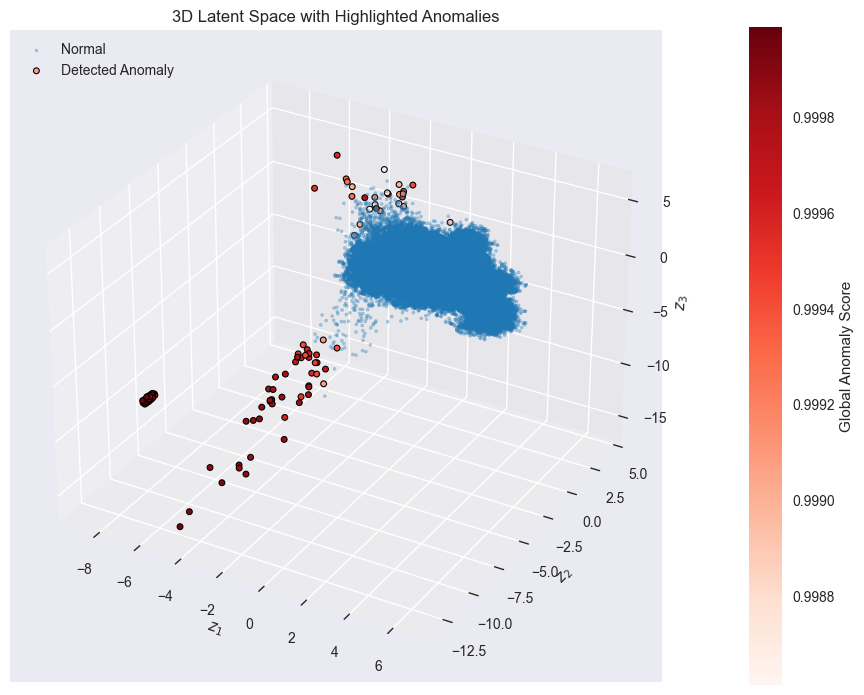

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

normal_idx  = preds == 0
anomaly_idx = preds == 1

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# -------- Normal points (BLUE) --------
ax.scatter(
    latent[normal_idx, 0],
    latent[normal_idx, 1],
    latent[normal_idx, 2],
    color="tab:blue",
    s=5,
    alpha=0.35,
    label="Normal"
)

# -------- Anomalies (RED, highlighted) --------
sc_anom = ax.scatter(
    latent[anomaly_idx, 0],
    latent[anomaly_idx, 1],
    latent[anomaly_idx, 2],
    c=ensemble_global[anomaly_idx],
    cmap="Reds",
    s=70,
    marker=".",
    edgecolors="black",
    linewidths=0.8,
    alpha=1.0,
    label="Detected Anomaly"
)

# Colorbar (for anomaly severity)
cbar = plt.colorbar(sc_anom, ax=ax, pad=0.1)
cbar.set_label("Global Anomaly Score")

# Labels
ax.set_title("3D Latent Space with Highlighted Anomalies")
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.set_zlabel(r"$z_3$")

# Legend
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()


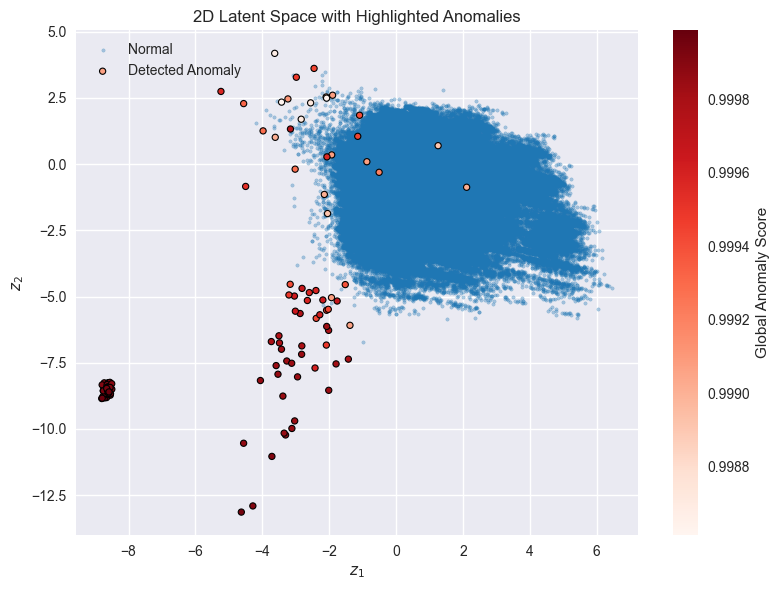

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Mask
normal_idx  = preds == 0
anomaly_idx = preds == 1

plt.figure(figsize=(8, 6))

# -------- Normal points (BLUE) --------
plt.scatter(
    latent[normal_idx, 0],
    latent[normal_idx, 1],
    color="tab:blue",
    s=6,
    alpha=0.35,
    label="Normal"
)

# -------- Anomalies (RED, highlighted) --------
sc_anom = plt.scatter(
    latent[anomaly_idx, 0],
    latent[anomaly_idx, 1],
    c=ensemble_global[anomaly_idx],
    cmap="Reds",
    s=80,
    marker=".",
    edgecolors="black",
    linewidths=0.8,
    alpha=1.0,
    label="Detected Anomaly"
)

# Colorbar for anomaly severity
cbar = plt.colorbar(sc_anom)
cbar.set_label("Global Anomaly Score")

# Labels
plt.title("2D Latent Space with Highlighted Anomalies")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

# Legend
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()
